# Use LSTM cells to predict defensive scores

Given the sequence of games, the idea is to use to structure the model as:

- Per team, use the opponents defense stats and the team's previous opponent defense stats to predict the upcoming defense stats 
- Add the teams as indexed variables and order data by home, away
- training data will be organized by team
    - for example, 49ers played Steelers week 1 and they'll play the Rams next week. The output should be the 49ers defense against the Rams. Input is 49ers defense and Ram's opponent defense (seahawks) on week 1. Though, Rams should be saved as the Week2 opponent team. Likewise, Steelers should be saved. The training sequence is all 49ers, so that information is irrelevant. Right? Or, maybe just include it...
    
*How to handle bye weeks?* Just drop these weeks? Or, take average of previous weeks? 
    Shouldn't matter, sequence lengths can differ

## Data preparation

--input--

team_index, home/away(\_t), opponent offense (\t-1) (essentially opponent's opponent defense \_t-1), 
    - should I include the 

--output--
defense(\_t)

In [294]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(1)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy

In [295]:
fdat = pd.read_csv("Madden/defense.csv", index_col=0)
fdat.sort_values("weekn", inplace=True)
fdat.tail()
# fdat['game'] = fdat.apply(lambda x: x['team'].strip() + str(x['weekn']), axis=1)
# fdat.head()

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
449,56.0,4.0,5.0,11.0,0.0,bal,sf,16,0,19,...,46,336,1,18.0,121.0,21.9,1.0,26.0,336.0,75.3
448,65.0,2.0,0.0,3.0,0.0,sf,bal,16,1,33,...,35,252,2,26.0,102.0,12.4,1.0,23.0,252.0,116.8
478,64.0,6.0,1.0,6.0,1.0,atl,ind,16,1,10,...,37,201,0,25.0,92.0,26.7,1.0,20.0,201.0,63.7
462,46.0,2.0,0.0,2.0,0.0,kc,lv,16,1,20,...,21,62,0,29.0,157.0,16.1,0.0,9.0,62.0,27.5
479,68.0,1.0,0.0,5.0,0.0,ind,atl,16,0,29,...,33,229,1,30.0,177.0,22.4,1.0,23.0,229.0,99.9


In [296]:
# making team to index
team_to_idx = dict(zip(fdat.team.unique(), np.arange(fdat.team.nunique())))
team_to_idx

{'kc': 0,
 'cin': 1,
 'cle': 2,
 'car': 3,
 'atl': 4,
 'jax': 5,
 'ind': 6,
 'hou': 7,
 'bal': 8,
 'min': 9,
 'ari': 10,
 'was': 11,
 'lv': 12,
 'den': 13,
 'mia': 14,
 'lac': 15,
 'tb': 16,
 'chi': 17,
 'gb': 18,
 'nyj': 19,
 'buf': 20,
 'nyg': 21,
 'dal': 22,
 'sea': 23,
 'lar': 24,
 'det': 25,
 'sf': 26,
 'no': 27,
 'ten': 28,
 'ne': 29,
 'phi': 30,
 'pit': 31}

In [297]:
fdat_ = fdat.copy()
fdat_.team = fdat_['team'].apply(lambda x: team_to_idx[x])
fdat_.opp = fdat_['opp'].apply(lambda x: team_to_idx[x])

## Testing on a single team, Dallas

In [6]:
fdat.loc[fdat.team == "dal",:].head()

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
5,64.0,7.0,2.0,8.0,3.0,dal,nyg,1,0,0,...,30,110,0,28.0,108.0,17.1,0.0,17.0,110.0,56.5
42,37.0,3.0,3.0,7.0,1.0,dal,nyj,2,1,10,...,27,170,1,16.0,64.0,19.3,0.0,12.0,170.0,77.0
81,60.0,2.0,0.0,1.0,0.0,dal,ari,3,0,28,...,21,189,1,30.0,222.0,37.8,2.0,17.0,189.0,79.2
108,52.0,2.0,2.0,5.0,1.0,dal,ne,4,1,3,...,30,207,0,23.0,53.0,7.1,0.0,16.0,207.0,103.8
143,76.0,1.0,0.0,5.0,1.0,dal,sf,5,0,42,...,25,253,4,41.0,170.0,18.1,2.0,18.0,253.0,95.1


### training data

In [87]:
tdat = fdat.loc[fdat.team == "dal",:]
tdat['team'] = tdat['team'].apply(lambda x: team_to_idx[x])
tdat['opp'] = tdat['opp'].apply(lambda x: team_to_idx[x])
tdat

/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_26597/2238823030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat['team'] = tdat['team'].apply(lambda x: team_to_idx[x])
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_26597/2238823030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat['opp'] = tdat['opp'].apply(lambda x: team_to_idx[x])


,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
5,64.0,7.0,2.0,8.0,3.0,5,4,1,0,0,...,30,110,0,28.0,108.0,17.1,0.0,17.0,110.0,56.5
42,37.0,3.0,3.0,7.0,1.0,5,2,2,1,10,...,27,170,1,16.0,64.0,19.3,0.0,12.0,170.0,77.0
81,60.0,2.0,0.0,1.0,0.0,5,21,3,0,28,...,21,189,1,30.0,222.0,37.8,2.0,17.0,189.0,79.2
108,52.0,2.0,2.0,5.0,1.0,5,12,4,1,3,...,30,207,0,23.0,53.0,7.1,0.0,16.0,207.0,103.8
143,76.0,1.0,0.0,5.0,1.0,5,9,5,0,42,...,25,253,4,41.0,170.0,18.1,2.0,18.0,253.0,95.1
159,52.0,1.0,1.0,6.0,0.0,5,16,6,0,17,...,37,227,2,23.0,53.0,11.2,0.0,22.0,227.0,62.7
242,52.0,2.0,1.0,5.0,0.0,5,7,8,1,20,...,32,204,1,24.0,92.0,20.5,1.0,18.0,204.0,77.1
259,60.0,3.0,0.0,1.0,2.0,5,13,9,0,28,...,23,207,2,33.0,109.0,17.3,2.0,17.0,207.0,67.6
274,48.0,5.0,1.0,6.0,0.0,5,4,10,1,17,...,27,86,2,23.0,111.0,15.0,0.0,14.0,86.0,44.0


In [35]:
opp_name = tdat.opp[tdat.weekn==i].iloc[0]
opp_name

4

In [43]:
fdat_.loc[fdat_['team']==opp_name,:].head()

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
16,45.0,0.0,1.0,10.0,0.0,16,17,1,1,36,...,45,466,3,20.0,70.0,16.9,1.0,28.0,466.0,104.5
53,78.0,5.0,0.0,1.0,0.0,16,11,2,0,27,...,24,246,1,34.0,141.0,21.3,2.0,20.0,246.0,109.4
73,65.0,4.0,1.0,8.0,1.0,16,22,3,0,24,...,50,367,3,24.0,130.0,23.7,0.0,32.0,367.0,100.2
106,62.0,7.0,1.0,3.0,2.0,16,19,4,1,17,...,39,238,0,23.0,76.0,9.4,2.0,24.0,238.0,72.0
158,58.0,5.0,0.0,2.0,0.0,16,5,6,1,20,...,30,272,1,26.0,96.0,25.7,1.0,21.0,272.0,62.0


In [53]:
any(fdat_.weekn[fdat_.team==opp_name] == 1)

True

In [109]:
opp_dat = []
for i in tdat.weekn:
    if i == 1:
        continue
    # check for bye weeks
    opp_name = tdat.opp[tdat.weekn==i].iloc[0]
    if any(fdat_.weekn[fdat_.team==opp_name] == i-1):
        opp_opp_name = fdat_.opp[(fdat_.weekn==i-1) & (fdat_.team==opp_name)].iloc[0]
        opp_dat.append(fdat_.loc[(fdat_.weekn==i-1) & (fdat_.opp==opp_opp_name)])
    else:
        opp_opp_name = fdat_.opp[(fdat_.weekn==i-2) & (fdat_.team==opp_name)].iloc[0]
        opp_dat.append(fdat_.loc[(fdat_.weekn==i-2) & (fdat_.opp==opp_opp_name)])
opp_df = pd.concat(opp_dat)
opp_df

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
2,70.0,5.0,3.0,4.0,1.0,2,3,1,1,16,...,41,236,1,22.0,97.0,20.8,0.0,29.0,236.0,65.3
44,60.0,3.0,1.0,7.0,0.0,21,4,2,1,31,...,37,321,2,27.0,127.0,15.3,2.0,26.0,321.0,102.0
69,54.0,3.0,0.0,5.0,1.0,12,2,3,0,10,...,36,157,0,22.0,38.0,5.8,1.0,18.0,157.0,68.0
114,64.0,1.0,0.0,0.0,0.0,9,21,4,1,16,...,41,265,2,25.0,105.0,13.7,0.0,28.0,265.0,52.7
106,62.0,7.0,1.0,3.0,2.0,16,19,4,1,17,...,39,238,0,23.0,76.0,9.4,2.0,24.0,238.0,72.0
194,57.0,2.0,0.0,2.0,1.0,7,8,7,1,24,...,25,230,0,29.0,86.0,10.1,3.0,17.0,230.0,59.7
225,63.0,1.0,1.0,6.0,1.0,13,20,8,0,31,...,52,397,4,16.0,84.0,16.6,0.0,39.0,397.0,85.1
251,62.0,0.0,0.0,2.0,0.0,4,19,9,0,30,...,25,209,0,34.0,125.0,28.3,3.0,16.0,209.0,108.5


In [110]:
tdat_train = tdat.loc[tdat.weekn!=10,:].copy()
tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
tdat_train.reset_index(inplace=True)
opp_df.reset_index(inplace=True)
training = pd.concat([tdat_train, opp_df], axis=1, ignore_index=False)
training

,index,Total_team,Sack_team,Int_team,PD_team,FF_team,team_team,opp_team,weekn_team,home_team,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
0,5,64.0,7.0,2.0,8.0,3.0,5,4,1,0,...,41,236,1,22.0,97.0,20.8,0.0,29.0,236.0,65.3
1,42,37.0,3.0,3.0,7.0,1.0,5,2,2,1,...,37,321,2,27.0,127.0,15.3,2.0,26.0,321.0,102.0
2,81,60.0,2.0,0.0,1.0,0.0,5,21,3,0,...,36,157,0,22.0,38.0,5.8,1.0,18.0,157.0,68.0
3,108,52.0,2.0,2.0,5.0,1.0,5,12,4,1,...,41,265,2,25.0,105.0,13.7,0.0,28.0,265.0,52.7
4,143,76.0,1.0,0.0,5.0,1.0,5,9,5,0,...,39,238,0,23.0,76.0,9.4,2.0,24.0,238.0,72.0
5,159,52.0,1.0,1.0,6.0,0.0,5,16,6,0,...,25,230,0,29.0,86.0,10.1,3.0,17.0,230.0,59.7
6,242,52.0,2.0,1.0,5.0,0.0,5,7,8,1,...,52,397,4,16.0,84.0,16.6,0.0,39.0,397.0,85.1
7,259,60.0,3.0,0.0,1.0,2.0,5,13,9,0,...,25,209,0,34.0,125.0,28.3,3.0,16.0,209.0,108.5


In [111]:
# drop some columns
training = training.loc[:,~training.columns.isin(['index','weekn_team','weekn'])]
training.loc[:,'home_next'] = tdat.iloc[1:,8].values
training.columns


/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_26597/1826687310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training.loc[:,'home_next'] = tdat.iloc[1:,8].values


Index(['Total_team', 'Sack_team', 'Int_team', 'PD_team', 'FF_team',
       'team_team', 'opp_team', 'home_team', 'points_team', 'pass_Comp_team',
       'pass_Att_team', 'pass_Yds_team', 'pass_TD_team', 'rush_Rush_team',
       'rush_Yds_team', 'rush_Avg_team', 'rush_TD_team', 'rec_Rec_team',
       'rec_Yds_team', 'rec_Avg_team', 'Total', 'Sack', 'Int', 'PD', 'FF',
       'team', 'opp', 'home', 'points', 'pass_Comp', 'pass_Att', 'pass_Yds',
       'pass_TD', 'rush_Rush', 'rush_Yds', 'rush_Avg', 'rush_TD', 'rec_Rec',
       'rec_Yds', 'rec_Avg', 'home_next'],
      dtype='object')

In [113]:
training=torch.tensor(training.to_numpy())

### Target data

In [201]:
targetdat = fdat.loc[fdat.team == "dal",:]
targetdat.columns

Index(['Total', 'Sack', 'Int', 'PD', 'FF', 'team', 'opp', 'weekn', 'home',
       'points', 'pass_Comp', 'pass_Att', 'pass_Yds', 'pass_TD', 'rush_Rush',
       'rush_Yds', 'rush_Avg', 'rush_TD', 'rec_Rec', 'rec_Yds', 'rec_Avg'],
      dtype='object')

In [202]:
targetdat = targetdat.loc[targetdat.weekn != 1,:]
targetdat = targetdat.loc[:,~targetdat.columns.isin(['team','opp','weekn','home'])]

In [203]:
targetdat

,Total,Sack,Int,PD,FF,points,pass_Comp,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
42,37.0,3.0,3.0,7.0,1.0,10,12,27,170,1,16.0,64.0,19.3,0.0,12.0,170.0,77.0
81,60.0,2.0,0.0,1.0,0.0,28,17,21,189,1,30.0,222.0,37.8,2.0,17.0,189.0,79.2
108,52.0,2.0,2.0,5.0,1.0,3,16,30,207,0,23.0,53.0,7.1,0.0,16.0,207.0,103.8
143,76.0,1.0,0.0,5.0,1.0,42,18,25,253,4,41.0,170.0,18.1,2.0,18.0,253.0,95.1
159,52.0,1.0,1.0,6.0,0.0,17,22,37,227,2,23.0,53.0,11.2,0.0,22.0,227.0,62.7
242,52.0,2.0,1.0,5.0,0.0,20,18,32,204,1,24.0,92.0,20.5,1.0,18.0,204.0,77.1
259,60.0,3.0,0.0,1.0,2.0,28,17,23,207,2,33.0,109.0,17.3,2.0,17.0,207.0,67.6
274,48.0,5.0,1.0,6.0,0.0,17,14,27,86,2,23.0,111.0,15.0,0.0,14.0,86.0,44.0


In [186]:
targetdat = torch.tensor(targetdat.to_numpy())

tensor([[ 37.0000,   3.0000,   3.0000,   7.0000,   1.0000,  10.0000,  12.0000,
          27.0000, 170.0000,   1.0000,  16.0000,  64.0000,  19.3000,   0.0000,
          12.0000, 170.0000,  77.0000],
        [ 60.0000,   2.0000,   0.0000,   1.0000,   0.0000,  28.0000,  17.0000,
          21.0000, 189.0000,   1.0000,  30.0000, 222.0000,  37.8000,   2.0000,
          17.0000, 189.0000,  79.2000],
        [ 52.0000,   2.0000,   2.0000,   5.0000,   1.0000,   3.0000,  16.0000,
          30.0000, 207.0000,   0.0000,  23.0000,  53.0000,   7.1000,   0.0000,
          16.0000, 207.0000, 103.8000],
        [ 76.0000,   1.0000,   0.0000,   5.0000,   1.0000,  42.0000,  18.0000,
          25.0000, 253.0000,   4.0000,  41.0000, 170.0000,  18.1000,   2.0000,
          18.0000, 253.0000,  95.1000],
        [ 52.0000,   1.0000,   1.0000,   6.0000,   0.0000,  17.0000,  22.0000,
          37.0000, 227.0000,   2.0000,  23.0000,  53.0000,  11.2000,   0.0000,
          22.0000, 227.0000,  62.7000],
        [ 

In [187]:
print(targetdat.shape)
print(training.shape)

torch.Size([8, 17])
torch.Size([8, 41])


## All data

In [298]:
fdat_.sort_values("weekn", inplace=True)
fdat_.head()

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
0,71.0,1.0,0.0,4.0,1.0,0,25,1,1,21,...,35,253,1,34.0,118.0,12.3,1.0,22.0,253.0,81.1
8,67.0,3.0,0.0,5.0,3.0,31,26,1,1,30,...,29,220,2,34.0,188.0,18.6,1.0,19.0,220.0,39.1
13,73.0,2.0,1.0,10.0,2.0,30,29,1,0,20,...,54,316,3,22.0,76.0,20.7,0.0,35.0,316.0,70.2
12,62.0,3.0,0.0,4.0,1.0,29,30,1,1,25,...,33,170,1,25.0,97.0,14.0,0.0,22.0,170.0,38.5
11,64.0,4.0,1.0,4.0,2.0,28,27,1,0,16,...,33,305,1,27.0,69.0,15.6,0.0,23.0,305.0,59.5


In [171]:
fdat_.opp

0      25
8      26
13     29
12     30
11     27
       ..
402    25
405    19
399    14
400    20
415     1
Name: opp, Length: 416, dtype: int64

In [299]:
training_dat = []
# for t in fdat_.team.unique():
for _, t in team_to_idx.items():
#     print(t)
    # team data
    tdat = fdat_.loc[fdat_.team == t,:]
    # all opponent data
    opp_dat = []
    teamid_dat = []
    for i in tdat.weekn:
        team_vector = np.zeros(len(team_to_idx))
        if i == 1:
            continue
        # check for bye weeks
        opp_name = tdat.opp[tdat.weekn==i].iloc[0]
        if any(fdat_.weekn[fdat_.team==opp_name] == i-1):
            opp_opp_name = fdat_.opp[(fdat_.weekn==i-1) & (fdat_.team==opp_name)].iloc[0]
            opp_opp_dat = fdat_.loc[(fdat_.weekn==i-1) & (fdat_.opp==opp_opp_name)]
        else:
            opp_opp_name = fdat_.opp[(fdat_.weekn==i-2) & (fdat_.team==opp_name)].iloc[0]
            opp_opp_dat = fdat_.loc[(fdat_.weekn==i-2) & (fdat_.opp==opp_opp_name)]
        # who did the team play last week?
        if any(fdat_.weekn[fdat_.team==t] == i-1):
            team_opp_name = fdat_.opp[(fdat_.weekn==i-1) & (fdat_.team==t)].iloc[0]
        else:
            team_opp_name = fdat_.opp[(fdat_.weekn==i-2) & (fdat_.team==t)].iloc[0]
        team_vector[opp_opp_name] = 2
        # team_vector[opp_name] = 4
        # team_vector[t] = 1
        team_vector[team_opp_name] = 1
        team_vector = pd.Series(team_vector)
#         opp_dat.append(team_vector.append(opp_opp_dat.iloc[0,:]))
        teamid_dat.append(team_vector)
        opp_dat.append(opp_opp_dat.iloc[0,:])
    opp_df = pd.DataFrame(opp_dat)
    teamid_df = pd.DataFrame(teamid_dat).to_numpy()
    tdat_train = tdat.loc[tdat.weekn!=tdat.weekn.max(),:].copy()
    tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
    tdat_train.reset_index(inplace=True)
    opp_df.reset_index(inplace=True)
    training = pd.concat([tdat_train, opp_df], axis=1, ignore_index=False)
    training = training.loc[:,~training.columns.isin(['index','weekn_team','weekn', 'team', 'opp', 'team_team', 'opp_team'])]
    training.loc[:,'home_next'] = tdat.iloc[1:,8].values
    training = training.to_numpy()
    training_scaler = StandardScaler()
    training_out = training_scaler.fit_transform(training)
    training_concat = np.concatenate([teamid_df, training_out], axis=1) 
    training = torch.tensor(training_concat)
    
    # target data
    targetdat = fdat_.loc[fdat_.team == t,:]
    targetdat = targetdat.loc[targetdat.weekn != 1,:]
    targetdat = targetdat.loc[:,targetdat.columns.isin(['points', 'pass_Yds', 'pass_TD', 'rush_Yds', 'rush_TD'])]
    # targetdat = targetdat.loc[:,targetdat.columns.isin(['points'])]
    targetdat = targetdat.to_numpy()
    target_scaler = StandardScaler()
    targetdat_out = target_scaler.fit_transform(targetdat)
    targetdat = torch.tensor(targetdat_out)
    
    training_dat.append([training, 
                         targetdat, 
                         (copy.deepcopy(training_scaler), copy.deepcopy(target_scaler))])

In [300]:
training_dat[0][0].shape

torch.Size([14, 69])

In [128]:
training_dat[1][1].shape

torch.Size([12, 1])

In [301]:
dat_train = [training_dat[i][0] for i in range(len(training_dat))]
dat_train = np.dstack(dat_train)
dat_train = np.moveaxis(dat_train, 2,0)
dat_train = torch.tensor(dat_train)

In [302]:
dat_target = [training_dat[i][1] for i in range(len(training_dat))]
dat_target = np.dstack(dat_target)
dat_target = np.moveaxis(dat_target, 2,0)
dat_target = torch.tensor(dat_target)

In [16]:
training_ds = torch.utils.data.TensorDataset(dat_train, dat_target)
training_loader = torch.utils.data.DataLoader(training_ds, batch_size=int(dat_train.size(0)/2), shuffle=True)

In [22]:
for i in range(3):
    print(i)
    for t_, _ in training_loader:
        for t_i, _i in zip(t_, _):
            print(t_i.shape)

0
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
1
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Size([12, 71])
torch.Siz

## Trying a model!

Try regularizing the result data

In [211]:
# EMBEDDING_DIM = 6
HIDDEN_DIM = 69
torch.set_default_dtype(torch.float64)

In [303]:
class LSTMDefense(nn.Module):

    def __init__(self, hidden_dim, n_stats, n_out):
        super(LSTMDefense, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(n_stats, hidden_dim)
        self.lstm = nn.LSTM(n_stats, hidden_dim, num_layers=1, dropout=0.)

        # The linear layer that maps from hidden state space to tag space
        # self.hidden2tag = nn.Linear(hidden_dim, n_stats)
        # self.tag2value = nn.Linear(n_stats, n_out)
        self.lmodel = nn.Sequential(
                    nn.Linear(hidden_dim, 20),
                    nn.ReLU(),
#                     nn.Linear(hidden_dim*2, hidden_dim),
#                     nn.ReLU(),
                    nn.Linear(20, n_out)
                )

    def forward(self, dat):
        dat_ = torch.reshape(dat, (dat.shape[0], 1, -1))
        lstm_out, _ = self.lstm(dat_)
        # tag_space = self.hidden2tag(Variable(lstm_out.view(dat.shape[0], -1)))
        # tag_score = self.tag2value(tag_space)
        tag_score = self.lmodel(lstm_out.view(dat.shape[0], -1))
#         return tag_space.squeeze()
#         tag_scores = F.softmax(tag_space, dim=1)
        return tag_score

In [304]:

model = LSTMDefense(HIDDEN_DIM, n_stats=69, n_out=5)
n_epochs = 500
# model = model.float()
# loss_function = nn.NLLLoss()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
v_score = []

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
# with torch.no_grad():
#     inputs = training_dat[1][0]
#     dat_ = torch.reshape(inputs, (inputs.shape[0], 1, -1))
#     tag_scores = model(dat_)
#     print(tag_scores)

for epoch in tqdm(range(n_epochs)):  
    # make a validation set
    loo_i = np.random.randint(len(training_dat))
    val_loo = training_dat[loo_i]
    train_loo = copy.deepcopy(training_dat)
    train_loo.pop(loo_i)
    
    # make a random subset of 6 weeks...from all training teams
    max_week = len(train_loo[0][0]) - 6
    train_loo_short = copy.deepcopy(train_loo)
    for t in train_loo_short:
        start_wk = np.random.randint(max_week)
        t[0] = t[0][start_wk:start_wk+6,:]
        t[1] = t[1][start_wk:start_wk+6,:]
    
    for inputs, results, _ in train_loo_short:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, results)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        inputs = val_loo[0]
        tag_scores = model(inputs)
        val_error = np.abs(tag_scores - val_loo[1]).sum()
        v_score.append(val_error.numpy())

100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 45.69it/s]


<Axes: xlabel='epoch', ylabel='error'>

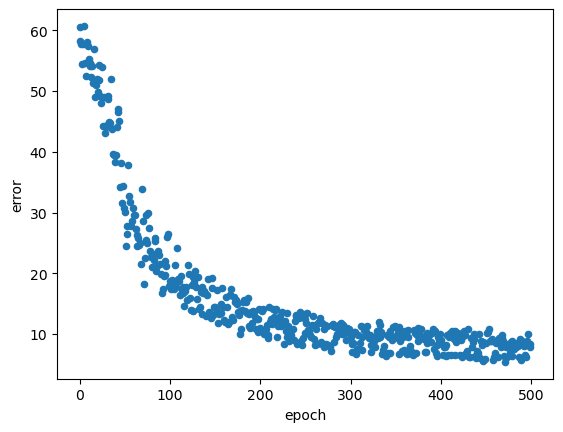

In [305]:
pdata = pd.DataFrame({'epoch':np.arange(n_epochs), 'error':v_score})
pdata.plot.scatter('epoch', 'error')

In [55]:
t_i = 23
with torch.no_grad():
    inputs = training_dat[t_i][0]
    tag_scores = model(inputs)
    print(training_dat[t_i][2][1].inverse_transform(tag_scores))

[[ 3.33172012e+01  3.20894196e+02  2.84568443e+00  1.00556519e+02
   8.87382965e-01]
 [ 2.70477870e+01  3.62024849e+02  1.98475783e+00  4.67529761e+01
   9.70145706e-01]
 [ 3.19173089e+00  2.02455498e+02 -6.36949252e-03  1.09951785e+02
   2.90537868e-03]
 [ 1.72369388e+01  1.86586359e+02  1.95069773e+00  4.69991756e+01
  -3.12022292e-02]
 [ 9.69860183e+00  1.49160969e+02  5.76004047e-02  1.25328036e+02
   1.02497394e+00]
 [ 2.09410556e+01  2.55873818e+02  9.43552003e-01  1.54148426e+02
   9.39845223e-01]
 [ 3.55709214e+01  2.24991429e+02  1.09456805e+00  2.98307161e+02
   3.08949534e+00]
 [ 2.58150848e+01  3.11831114e+02  3.02945718e+00  6.81575846e+01
   1.83586172e-02]
 [ 1.52836053e+01  1.89980526e+02  1.10002462e+00  8.40177107e+01
   1.05726761e+00]
 [ 3.16182862e+01  2.11777475e+02  9.17008516e-01  1.70882693e+02
   2.96200725e+00]
 [ 3.75831674e+01  3.00461530e+02  3.25037756e+00  1.36775950e+02
   1.18591606e+00]]


In [56]:
training_dat[t_i][2][1].inverse_transform(training_dat[t_i][1])

array([[ 31., 323.,   3., 102.,   1.],
       [ 27., 361.,   2.,  44.,   1.],
       [  3., 203.,   0., 112.,   0.],
       [ 17., 185.,   2.,  46.,   0.],
       [ 10., 150.,   0., 127.,   1.],
       [ 20., 257.,   1., 155.,   1.],
       [ 37., 225.,   1., 298.,   3.],
       [ 26., 312.,   3.,  68.,   0.],
       [ 17., 190.,   1.,  82.,   1.],
       [ 31., 209.,   1., 169.,   3.],
       [ 41., 299.,   3., 136.,   1.]])

In [94]:
training_dat[8][2]

(StandardScaler(), StandardScaler())

In [34]:

team_dict_df = pd.DataFrame(team_to_idx, index=["key"])
idx_to_team = dict(zip(team_dict_df.loc["key"],team_dict_df.columns))
idx_to_team

{0: 'kc',
 1: 'cin',
 2: 'cle',
 3: 'car',
 4: 'atl',
 5: 'jax',
 6: 'ind',
 7: 'hou',
 8: 'bal',
 9: 'min',
 10: 'ari',
 11: 'was',
 12: 'lv',
 13: 'den',
 14: 'mia',
 15: 'lac',
 16: 'tb',
 17: 'chi',
 18: 'gb',
 19: 'nyj',
 20: 'buf',
 21: 'nyg',
 22: 'dal',
 23: 'sea',
 24: 'lar',
 25: 'det',
 26: 'sf',
 27: 'no',
 28: 'ten',
 29: 'ne',
 30: 'phi',
 31: 'pit'}

In [222]:
team_to_idx

{'kc': 0,
 'cin': 1,
 'cle': 2,
 'car': 3,
 'atl': 4,
 'jax': 5,
 'ind': 6,
 'hou': 7,
 'bal': 8,
 'min': 9,
 'ari': 10,
 'was': 11,
 'lv': 12,
 'den': 13,
 'mia': 14,
 'lac': 15,
 'tb': 16,
 'chi': 17,
 'gb': 18,
 'nyj': 19,
 'buf': 20,
 'nyg': 21,
 'dal': 22,
 'sea': 23,
 'lar': 24,
 'det': 25,
 'sf': 26,
 'no': 27,
 'ten': 28,
 'ne': 29,
 'phi': 30,
 'pit': 31}

## Trying a new prediction!

Dallas (25) vs. Seahawks (23)


In [35]:
new_matches = [(15,12), (9,1), (31,6), (13,25), (21,27), (17,2), (4,3),
              (16,18), (19,14), (0,29), (7,28), (26,10), (11,24), (22,20), (8,5), (30,23)]
len(new_matches)

16

In [306]:
# week 15
# new_matches = [('lac','lv'), ('min','cin'), ('pit','ind'), ('den','det'), ('nyg','no'), ('chi','cle'), ('atl','car'),
#               ('tb','gb'), ('nyj','mia'), ('kc','ne'), ('hou','ten'), ('sf','ari'), 
#                ('was','lar'), ('den','buf'), ('bal','jax'), ('phi','sea')]

# # week 16
# new_matches = [('no','lar'), ('cin','pit'), ('buf','lac'), ('was','nyj'), ('det','min'), ('cle','hou'), ('gb','car'),
#               ('sea','ten'), ('ind','atl'), ('jax','tb'), ('dal','mia'), ('ari','chi'), 
#                ('ne','den'), ('lv','kc'), ('nyg','phi'), ('bal','sf')]
# week 17
new_matches = [('nyj','cle'), ('det','dal'), ('ten','hou'), ('atl','chi'), ('mia','bal'), ('no','tb'), ('ne','buf'),
              ('ari','phi'), ('car','jax'), ('lv','ind'), ('lar','nyg'), ('sf','was'), 
               ('pit','sea'), ('cin','kc'), ('lac','den'), ('gb','min')]

In [52]:
weekn=15
games=(15,12)
teami = games[1]
teamj = games[0]
at_home = 1
if weekn-1 in fdat_.weekn[fdat_.team==teami].values:
    tdat_train = fdat_.loc[(fdat_.team == teami) & (fdat_.weekn == weekn-1),:]
else:
    tdat_train = fdat_.loc[(fdat_.team == teami) & (fdat_.weekn == weekn-2),:]

team_vector = np.zeros(len(team_to_idx))
if any(fdat_.weekn[fdat_.team==teamj].values == weekn-1):
    opp_opp_name = fdat_.opp[(fdat_.weekn==weekn-1) & (fdat_.team==teamj)].iloc[0]
    opp_opp_dat = fdat_.loc[(fdat_.weekn==weekn-1) & (fdat_.opp==opp_opp_name)]
else:
    opp_opp_name = fdat_.opp[(fdat_.weekn==weekn-2) & (fdat_.team==teamj)].iloc[0]
    opp_opp_dat = fdat_.loc[(fdat_.weekn==weekn-2) & (fdat_.opp==opp_opp_name)]
team_vector[opp_opp_name] = 1
team_vector[teamj] = 2
teamid_df = pd.DataFrame(team_vector).T.to_numpy()
tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
tdat_train.reset_index(inplace=True)
opp_opp_dat.reset_index(inplace=True)
training = pd.concat([tdat_train, opp_opp_dat], axis=1, ignore_index=False)
training = training.loc[:,~training.columns.isin(['index','weekn_team','weekn', 'team', 'team_team'])]
training['home_next'] = at_home
training = training.to_numpy()
# training_out = training_dat[teami][2][0].transform(training)
# training_concat = np.concatenate([teamid_df, training_out], axis=1)
# training_concat = np.concatenate([training_dat[teami][0], training_concat])
# inputs = torch.tensor(training_concat)

/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/3629033428.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)


In [311]:
def prepareNewGames(games, weekn, fdat_=fdat_, training_dat = training_dat, model=model):
    outs = []
    for i in range(2):
        if i == 0:
            teami = games[0]
            teamj = games[1]
            at_home = 0
        else:
            teami = games[1]
            teamj = games[0]
            at_home = 1
        
        if weekn-1 in fdat_.weekn[fdat_.team==teami].values:
            tdat_train = fdat_.loc[(fdat_.team == teami) & (fdat_.weekn == weekn-1),:]
        else:
            tdat_train = fdat_.loc[(fdat_.team == teami) & (fdat_.weekn == weekn-2),:]

        team_vector = np.zeros(len(team_to_idx))
        if any(fdat_.weekn[fdat_.team==teamj].values == weekn-1):
            opp_opp_name = fdat_.opp[(fdat_.weekn==weekn-1) & (fdat_.team==teamj)].iloc[0]
            opp_opp_dat = fdat_.loc[(fdat_.weekn==weekn-1) & (fdat_.opp==opp_opp_name)]
        else:
            opp_opp_name = fdat_.opp[(fdat_.weekn==weekn-2) & (fdat_.team==teamj)].iloc[0]
            opp_opp_dat = fdat_.loc[(fdat_.weekn==weekn-2) & (fdat_.opp==opp_opp_name)]
            
        if any(fdat_.weekn[fdat_.team==teami] == weekn-1):
            team_opp_name = fdat_.opp[(fdat_.weekn==weekn-1) & (fdat_.team==teami)].iloc[0]
        else:
            team_opp_name = fdat_.opp[(fdat_.weekn==weekn-2) & (fdat_.team==teami)].iloc[0]
            
        team_vector[opp_opp_name] = 2
        team_vector[team_opp_name] = 1
        teamid_df = pd.DataFrame(team_vector).T.to_numpy()
        tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
        tdat_train.reset_index(inplace=True)
        opp_opp_dat.reset_index(inplace=True)
        training = pd.concat([tdat_train, opp_opp_dat], axis=1, ignore_index=False)
        training = training.loc[:,~training.columns.isin(['index','weekn_team','weekn', 'team', 'opp','team_team', 'opp_team'])]
        training['home_next'] = at_home
        training = training.to_numpy()
        
        training_out = training_dat[teami][2][0].transform(training)
        training_concat = np.concatenate([teamid_df, training_out], axis=1)
        # training_concat = np.concatenate([training_dat[teami][0], training_concat])
        # Trying with only 6 most recent games
        training_concat = np.concatenate([training_dat[teami][0][-5:,:], training_concat])
        inputs = torch.tensor(training_concat)
#         outs.append(torch.tensor(training_concat))
        with torch.no_grad():
            l_f = nn.MSELoss()
            tag_scores = model(inputs)
            preds = training_dat[teami][2][1].inverse_transform(tag_scores)
            # team_loss = l_f(tag_scores[:-1,0], training_dat[teami][1][:,0])
            # with only 3 most recent games
            team_loss = l_f(tag_scores[:-1,0], training_dat[teami][1][-5:,0])
            preds_new = preds[-1,:]
            preds_new = np.concatenate((preds_new, [team_loss]))
            outs.append(preds_new)
    return(np.vstack(outs))

In [312]:
for match in new_matches:
    print(match[0]+" vs. "+match[1])
    scores = prepareNewGames((team_to_idx[match[0]], team_to_idx[match[1]]),17)
    # print(idx_to_team[match[0]]+" vs. "+idx_to_team[match[1]])
    # scores = prepareNewGames((match[0], match[1]),15)
    print(scores)

nyj vs. cle
[[2.24350398e+01 7.16360005e+01 5.91703983e-01 1.44853415e+02
  8.45785532e-01 8.48945272e-01]
 [2.29534956e+01 2.76917396e+02 1.34422931e+00 7.35861524e+01
  1.42878280e+00 8.83350942e-02]]
det vs. dal
[[ 29.0098312  187.14546729   2.38010731  93.39726911   1.62108037
    0.21728202]
 [ 15.99906326 171.96062749   2.00897101 151.22447032   1.43728333
    0.52683107]]
ten vs. hou
[[ 1.94877117e+01  1.88474395e+02 -9.31606107e-02  9.85854705e+01
   2.14104165e+00  1.96954011e-01]
 [ 1.11162085e+01  2.08450015e+02  1.11847123e-01  9.30667879e+01
   7.62956193e-01  2.22274562e-01]]
atl vs. chi
[[2.43151479e+01 2.26105880e+02 3.42918101e+00 9.57121216e+01
  4.08963173e-01 1.22184118e+00]
 [1.86845867e+01 2.35173236e+02 1.22442227e+00 1.36134836e+02
  1.16566879e+00 5.96848730e-03]]
mia vs. bal
[[2.05566821e+01 3.42368543e+02 1.04335895e+00 2.11295900e+00
  1.55576030e+00 2.69575394e-01]
 [1.92211218e+01 2.21939838e+02 1.47948596e+00 1.47769602e+02
  2.91512367e-01 1.14196232e-01

/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [286]:
for match in new_matches:
    print(match[0]+" vs. "+match[1])
    scores = prepareNewGames((team_to_idx[match[0]], team_to_idx[match[1]]),16)
    # print(idx_to_team[match[0]]+" vs. "+idx_to_team[match[1]])
    # scores = prepareNewGames((match[0], match[1]),15)
    print(scores)

no vs. lar
[[1.74633966e+01 1.85117674e+02 1.05796414e+00 7.41832563e+01
  6.62948777e-01 3.90420953e-01]
 [2.40705162e+01 2.04602199e+02 2.90848334e-02 1.79922594e+02
  1.93515665e+00 4.43612095e-02]]
cin vs. pit
[[1.67442127e+01 2.23112707e+02 7.54582626e-01 1.17885957e+02
  1.04376949e+00 2.04424996e-01]
 [2.08063304e+01 2.86981521e+02 1.87787364e+00 1.45582717e+02
  1.34019572e+00 4.67054339e-01]]
buf vs. lac
[[ 2.62635378e+01  3.00232647e+02  6.23711546e-01  1.68948947e+02
   2.74225061e+00  1.93375871e-01]
 [ 1.41856038e+01  2.10039467e+02 -8.62553669e-01  1.73586503e+02
   2.33836141e+00  1.24563044e+00]]
was vs. nyj
[[2.96949310e+01 3.39767915e+02 2.89158388e+00 5.92639122e+01
  4.84522063e-02 3.45472203e-01]
 [2.43422754e+01 1.64029038e+02 1.80844790e+00 1.21696180e+02
  7.36356328e-01 1.84728398e-01]]
det vs. min
[[ 1.65492261e+01  2.10035183e+02  4.41215883e-01  9.56953283e+01
   4.67045739e-01  2.44909634e-02]
 [ 1.51547926e+01  1.20201393e+02  1.44717503e+00  1.62073366e+0

/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/1608678285.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [225]:
i=16
teami=4
fdat_.opp[(fdat_.weekn==i-2) & (fdat_.team==teami)].iloc[0]

16

In [101]:
for match in new_matches:
    # print(match[0]+" vs. "+match[1])
    # scores = prepareNewGames((team_to_idx[match[0]], team_to_idx[match[1]]),14)
    print(idx_to_team[match[0]]+" vs. "+idx_to_team[match[1]])
    scores = prepareNewGames((match[0], match[1]),15)
    print(scores)

lac vs. lv
[[1.83519563e+01 1.98615746e+02 1.46691063e+00 1.09950877e+02
  6.75282466e-01 1.93201515e-03]
 [2.45045899e+01 1.90426946e+02 1.63822722e+00 1.10748309e+02
  2.27189892e+00 4.56296164e-03]]
min vs. cin
[[2.13445603e+01 3.11662876e+02 1.73432331e+00 8.40919938e+01
  8.78508417e-01 4.62694345e-03]
 [2.38910884e+01 2.82432698e+02 1.43987142e+00 8.93365869e+01
  7.00524101e-01 1.83166745e-03]]
pit vs. ind
[[1.83486270e+01 2.59811579e+02 1.82273849e+00 1.60341899e+02
  1.25040144e+00 2.17935771e-03]
 [1.49900860e+01 2.22882684e+02 8.56066619e-02 8.98215750e+01
  2.64680060e+00 4.79949403e-03]]
den vs. det
[[1.85619819e+01 3.31369529e+02 1.83168058e+00 2.23423900e+02
  1.11489756e+00 4.19972120e-03]
 [3.35573003e+01 2.59069673e+02 2.38337757e+00 1.39790352e+02
  1.00003486e+00 2.23701379e-03]]
nyg vs. no
[[ 2.17299456e+01  3.34261266e+02  1.01274446e+00  1.29539663e+02
   2.61199794e-01  4.63477830e-03]
 [ 7.89900886e+00  1.82846328e+02  1.52968419e-01  6.66590961e+01
  -3.542434

/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/2160870225.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/2160870225.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdat_train.rename(columns = dict(zip(tdat_train.columns, tdat_train.columns + "_team")), inplace=True)
/var/folders/qz/80bqrsy90pj24jdm4b1q067czx01fz/T/ipykernel_69182/2160870225.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [170]:
np.vstack(scores)

array([[ 43.80221218, 390.41143975,   2.80761398, 108.05158017,
          1.63825635],
       [ 29.1093508 , 364.63253781,   1.06353375,  46.83844137,
          2.22656373]])

In [151]:
with torch.no_grad():
    tag_scores = model(inputs[0])
    print(training_dat[6][2][1].inverse_transform(tag_scores))

[[ 2.30172544e+01  2.76557509e+02  1.32143854e+00  8.92959515e+01
   1.00498599e+00]
 [ 1.14802462e+01  1.71072860e+02 -3.85359352e-01  5.76320612e+01
   6.53684362e-01]
 [ 1.76495911e+01  2.62395549e+02  1.90981068e+00  1.01160436e+02
  -4.25682223e-02]
 [ 1.06901526e+01  1.63156274e+02  8.13979917e-01  5.30050881e+01
  -2.02601127e-02]
 [ 1.88448653e+01  1.67691506e+02  3.54167126e-01  1.53390710e+02
   1.07408800e+00]
 [ 2.21618123e+01  3.47307842e+02  2.35793461e+00  5.95911316e+01
   1.79146820e-01]
 [ 3.18124169e+01  2.89865362e+02  2.79579615e+00  1.40152287e+02
   8.79987998e-01]
 [ 3.68080352e+00  2.00268531e+02 -5.34749284e-02  5.17379238e+01
   2.61700364e-02]
 [ 1.76047167e+01  2.20707621e+02  7.88645363e-01  7.12433207e+01
   7.91288490e-01]
 [ 9.92815089e+00  1.85379556e+02  2.58233898e-01  8.15142813e+01
   2.48698576e-01]
 [ 1.28161933e+01  5.09925066e+01 -2.67543736e-01  1.74507642e+02
   7.35487012e-01]]


In [100]:
tdat = fdat_.loc[fdat_.team == 25,:]
tdat

,Total,Sack,Int,PD,FF,team,opp,weekn,home,points,...,pass_Att,pass_Yds,pass_TD,rush_Rush,rush_Yds,rush_Avg,rush_TD,rec_Rec,rec_Yds,rec_Avg
5,64.0,7.0,2.0,8.0,3.0,25,22,1,0,0,...,30,110,0,28.0,108.0,17.1,0.0,17.0,110.0,56.5
42,37.0,3.0,3.0,7.0,1.0,25,20,2,1,10,...,27,170,1,16.0,64.0,19.3,0.0,12.0,170.0,77.0
81,60.0,2.0,0.0,1.0,0.0,25,10,3,0,28,...,21,189,1,30.0,222.0,37.8,2.0,17.0,189.0,79.2
108,52.0,2.0,2.0,5.0,1.0,25,29,4,1,3,...,30,207,0,23.0,53.0,7.1,0.0,16.0,207.0,103.8
143,76.0,1.0,0.0,5.0,1.0,25,26,5,0,42,...,25,253,4,41.0,170.0,18.1,2.0,18.0,253.0,95.1
159,52.0,1.0,1.0,6.0,0.0,25,15,6,0,17,...,37,227,2,23.0,53.0,11.2,0.0,22.0,227.0,62.7
242,52.0,2.0,1.0,5.0,0.0,25,24,8,1,20,...,32,204,1,24.0,92.0,20.5,1.0,18.0,204.0,77.1
259,60.0,3.0,0.0,1.0,2.0,25,30,9,0,28,...,23,207,2,33.0,109.0,17.3,2.0,17.0,207.0,67.6
274,48.0,5.0,1.0,6.0,0.0,25,22,10,1,17,...,27,86,2,23.0,111.0,15.0,0.0,14.0,86.0,44.0
319,64.0,6.0,1.0,2.0,1.0,25,3,11,0,10,...,29,123,1,23.0,110.0,11.7,0.0,16.0,123.0,49.8
